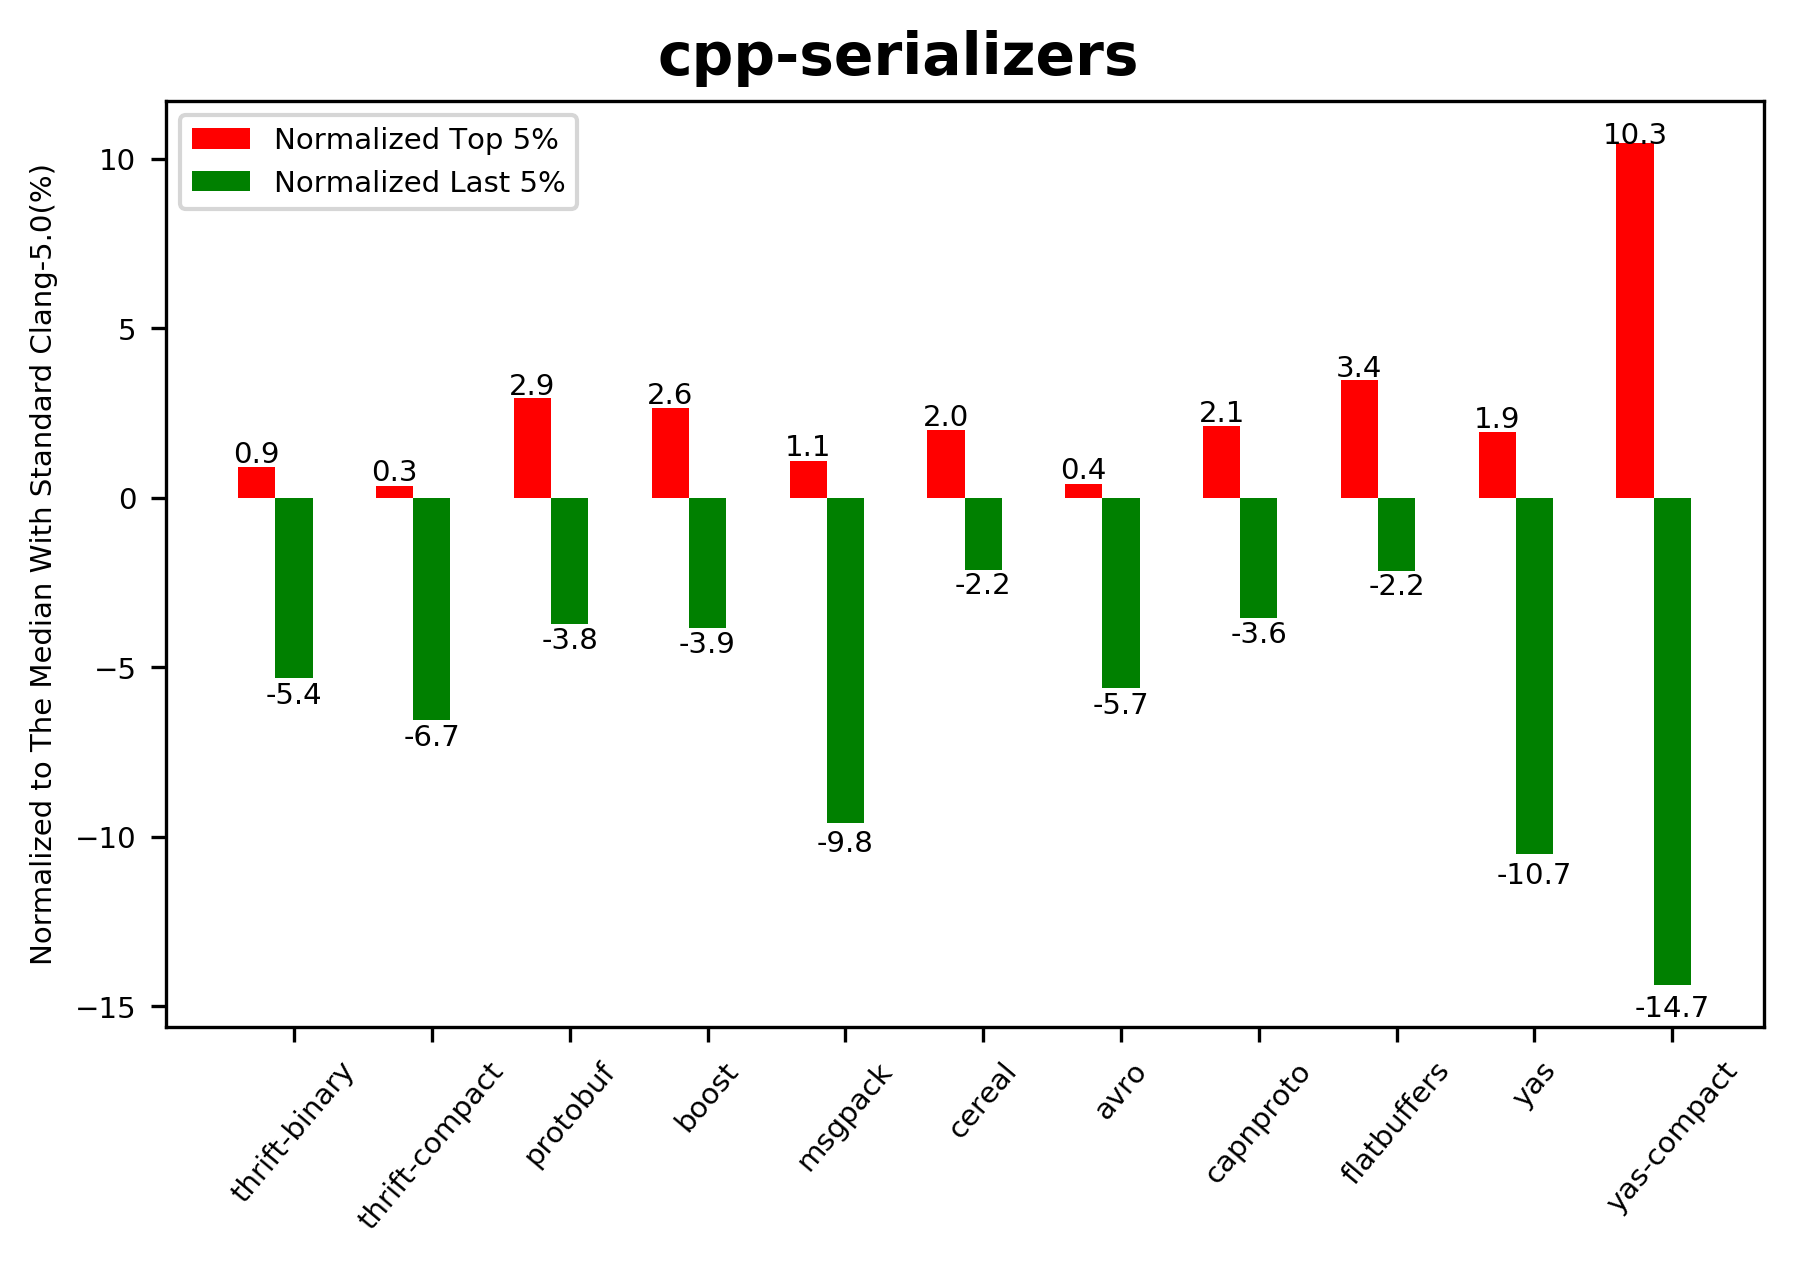

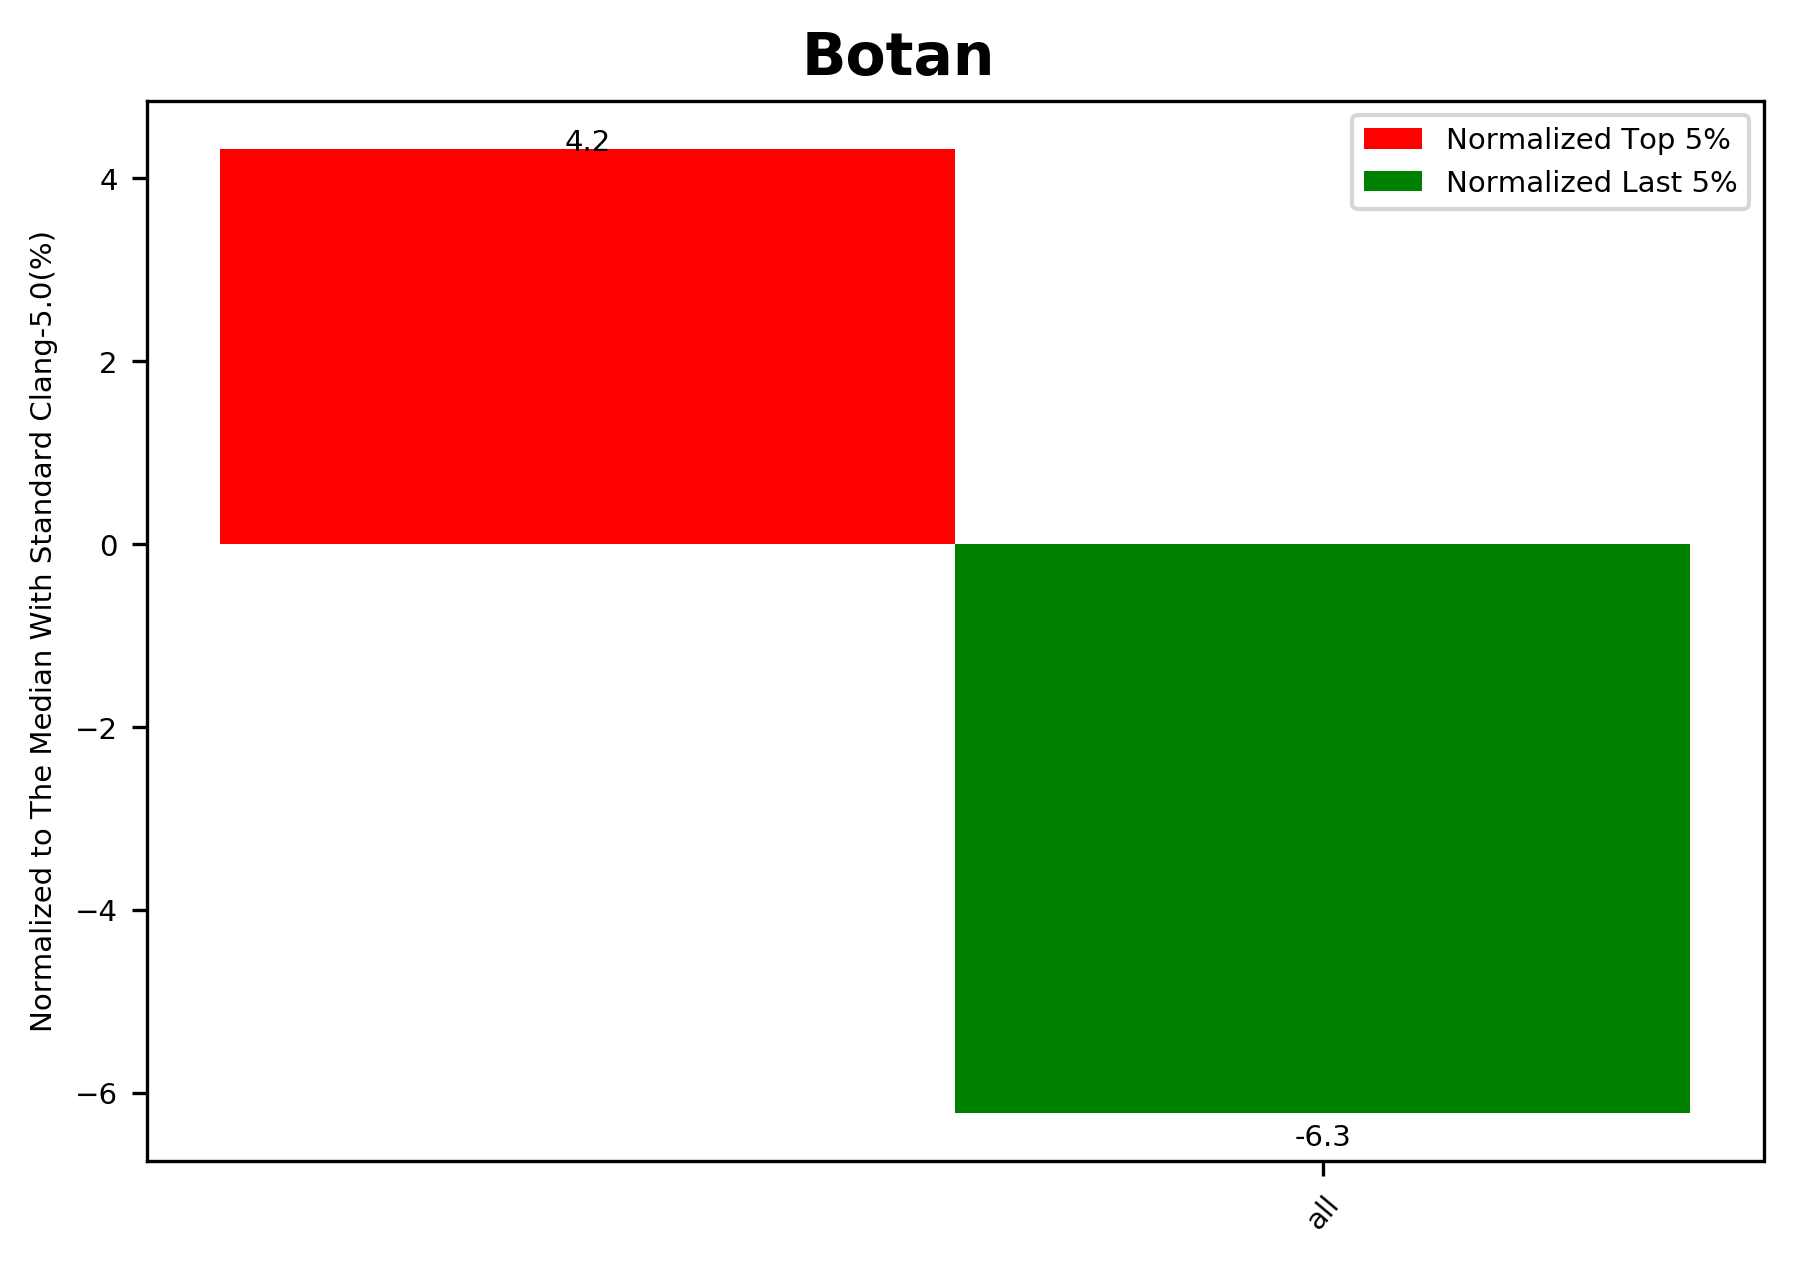

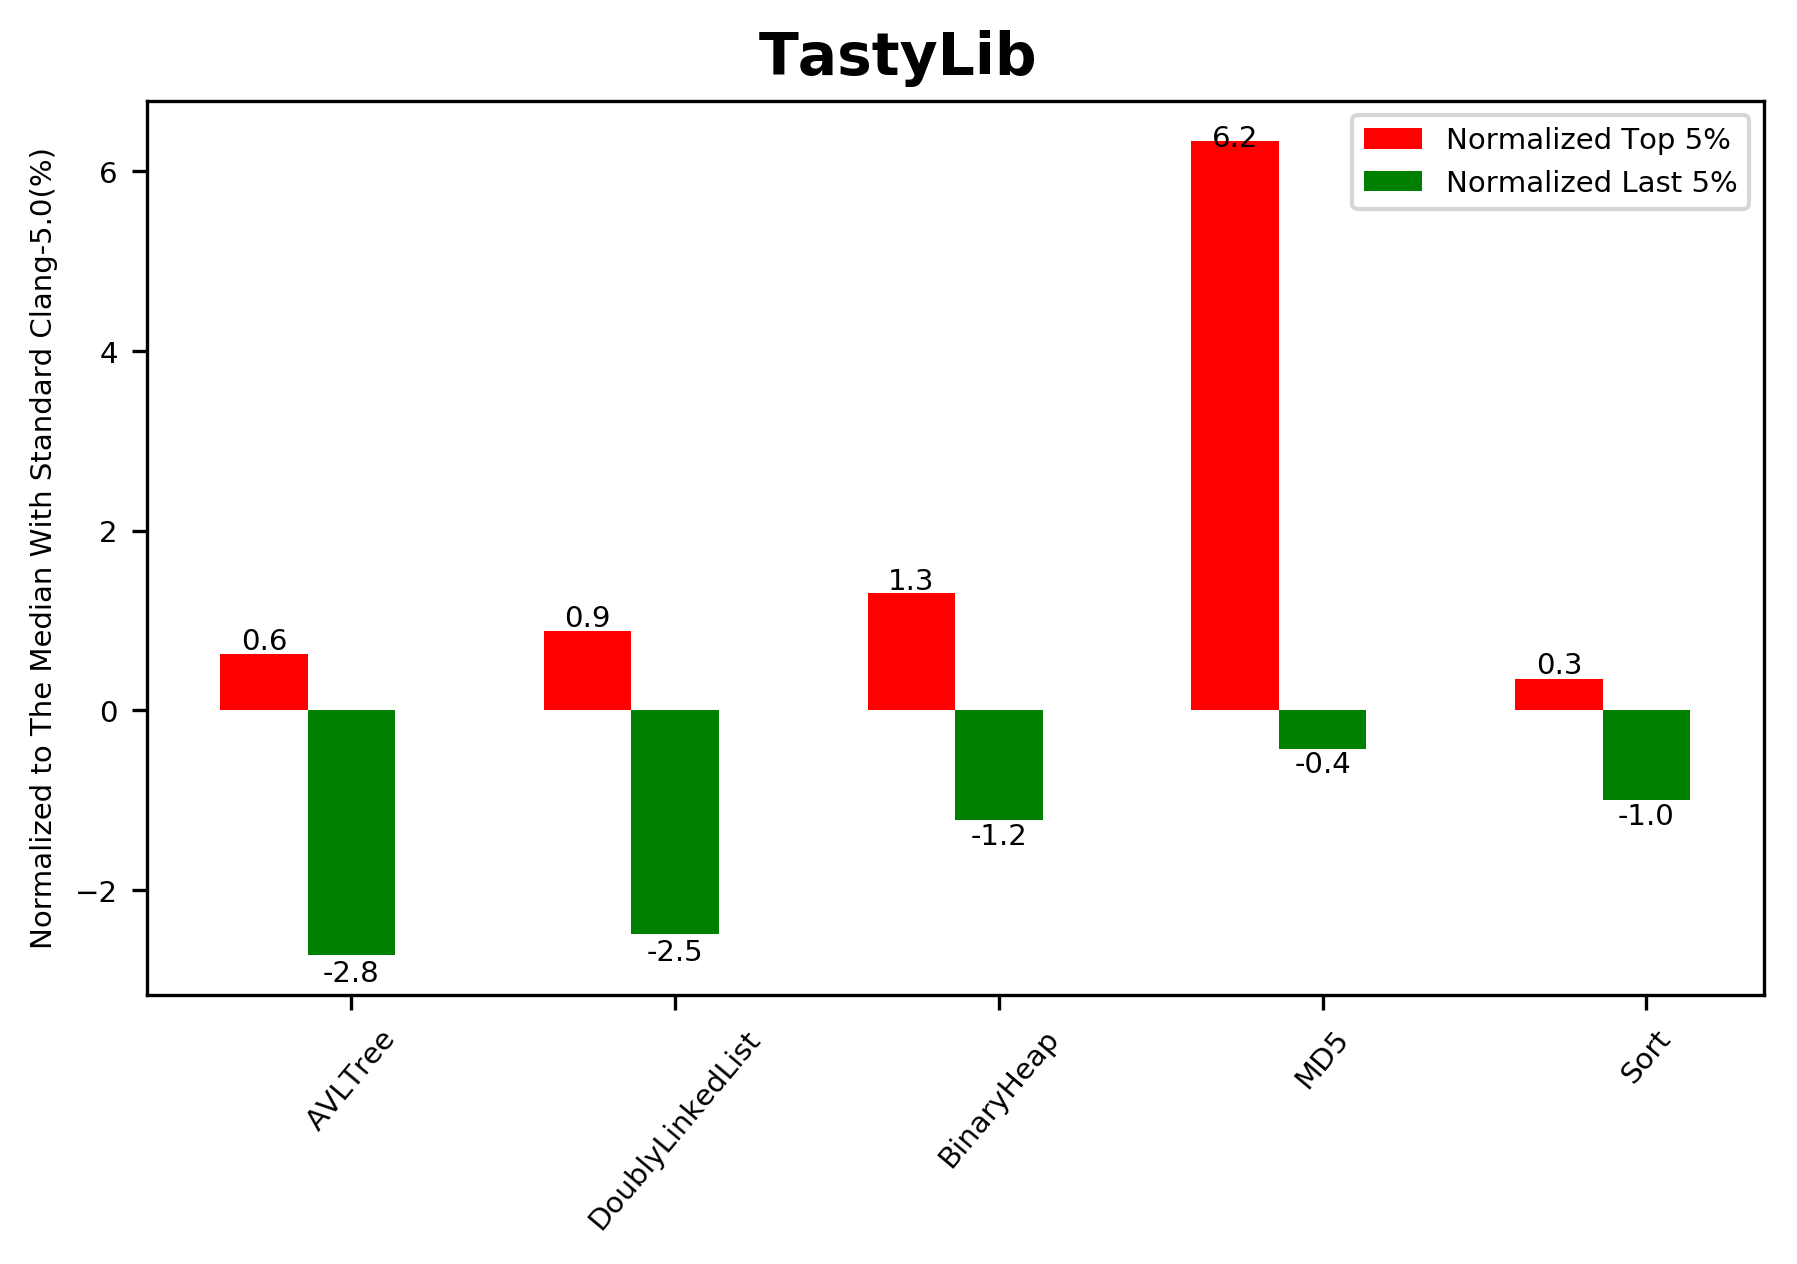

In [2]:
#!/usr/bin/python3
import os
import glob
import numpy as np
import matplotlib.pyplot as plt

class BenchmarkDataClassfier:
    #Format: {'benchmark name': {sub-benchmark name: [value 1, value 2, ...], ...}, ...}
    RandomBenchmarkDictLists = None
    StdBenchmarkDictLists = None
    #Format: [["benchmark name", "benchmark prefix"], ...]
    BenchmarkName = [["cpp-serializers", "cpp-serializers-"], ["Botan", "botan-"], ["TastyLib", "TastyLib-benchmark_"]]
    #Format: {'benchmark name' : [[list for normalized top 5%], [list for normalized last 5%]]}
    NormalizedSpeedList = None
    #Skip the data of the list of benchmarks
    FaultBenchmarkList = ['TastyLib-benchmark_NPuzzle']
    
    def __init__(self):
        self.RandomBenchmarkDictLists = {key[0]: {} for key in self.BenchmarkName}
        self.StdBenchmarkDictLists = {key[0]: {} for key in self.BenchmarkName}
        self.NormalizedSpeedList = {key[0]: [[], []] for key in self.BenchmarkName}
        
    def isFaultBenchmarks(self, name):
        for skip in self.FaultBenchmarkList:
            if name == skip:
                return True
        return False

    def RandomDictListGenerator(self):
        FileList = glob.glob("./result_data/*")
        for DataFile in FileList:
            if not DataFile.endswith("STD"):
                with open(DataFile, "r") as filestream:
                    for line in filestream:
                        currentline = line.rstrip().split(",")
                        if self.isFaultBenchmarks(currentline[0]):
                            continue
                        for bName in self.BenchmarkName:
                            # if match the prefix
                            if currentline[0].startswith(bName[1]):
                                SubBenchmarkKey = currentline[0][len(bName[1]):]
                                BenchmarkKey = bName[0]
                                # check for sub-benchmark exists
                                if not SubBenchmarkKey in self.RandomBenchmarkDictLists[BenchmarkKey]:
                                    self.RandomBenchmarkDictLists[BenchmarkKey][SubBenchmarkKey] = []
                                #Insert value
                                #Standard Clang need to chang from 2 to 1 due to the data format
                                self.RandomBenchmarkDictLists[BenchmarkKey][SubBenchmarkKey].append((float(currentline[2])))
        return self.RandomBenchmarkDictLists
    
    def StdDictListGenerator(self):
        FileList = glob.glob("./result_data/*")
        for DataFile in FileList:
            if DataFile.endswith("STD"):
                with open(DataFile, "r") as filestream:
                    for line in filestream:
                        currentline = line.rstrip().split(",")
                        if self.isFaultBenchmarks(currentline[0]):
                            continue
                        for bName in self.BenchmarkName:
                            # if match the prefix
                            if currentline[0].startswith(bName[1]):
                                SubBenchmarkKey = currentline[0][len(bName[1]):]
                                BenchmarkKey = bName[0]
                                # check for sub-benchmark exists
                                if not SubBenchmarkKey in self.StdBenchmarkDictLists[BenchmarkKey]:
                                    self.StdBenchmarkDictLists[BenchmarkKey][SubBenchmarkKey] = []
                                #Insert value
                                #Random Clang need to chang from 1 to 2 due to the data format
                                self.StdBenchmarkDictLists[BenchmarkKey][SubBenchmarkKey].append((float(currentline[1])))
        return self.StdBenchmarkDictLists
    
    def GraphGenerator_AutoLabel(self, rects, ax, location):
        horizontalAlign = 'center'
        if location == "up":
            verticalAlign='bottom'
        else:
            verticalAlign='top'
            
        for rect in rects:
            h = rect.get_height()
            if location == "up":
                h = h * 0.98
            else:
                h = h * 1.02
            label = "%.1f" % (h)
            ax.text(rect.get_x()+rect.get_width()/2., h, label,
                    ha=horizontalAlign, va=verticalAlign)

    def GraphGenerator(self, RandomBenchDictLists, StdBenchDictLists):
        for bmKey in StdBenchDictLists:
            for subKey in StdBenchDictLists[bmKey]:
                StdBenchDictLists[bmKey][subKey] = sorted(StdBenchDictLists[bmKey][subKey])
                RandomBenchDictLists[bmKey][subKey] = sorted(RandomBenchDictLists[bmKey][subKey])
                #Std mid value
                mid_idx = len(StdBenchDictLists[bmKey][subKey]) // 2
                Std_value = StdBenchDictLists[bmKey][subKey][mid_idx]
                #print("Std time={}".format(Std_value))
                
                #Leading 5% avg value
                sum = 0
                count = 0
                idx = int(len(RandomBenchDictLists[bmKey][subKey]) * 0.05 + 1)
                '''
                for idx_range in range(idx+1):
                    #Assume that speedup too much will cause error
                    if RandomBenchDictLists[bmKey][subKey][idx_range] * 3 < Std_value:
                        continue
                    sum += RandomBenchDictLists[bmKey][subKey][idx_range]
                    count += 1
                if sum == 0:
                    for idx_range in range(idx+1, len(RandomBenchDictLists[bmKey][subKey])):
                        if not RandomBenchDictLists[bmKey][subKey][idx_range] * 3 < Std_value:
                            sum = RandomBenchDictLists[bmKey][subKey][idx_range]
                            count = 1
                            break
                '''
                for idx_range in range(idx+1):
                    sum += RandomBenchDictLists[bmKey][subKey][idx_range]
                    count += 1
                Leading_value = sum / count
                #print("Leading 5%={}".format(Leading_value))
                #Last 5% avg value
                sum = 0
                count = 0
                idx = int(len(RandomBenchDictLists[bmKey][subKey]) * 0.95 + 1)
                for idx_range in range(idx, len(RandomBenchDictLists[bmKey][subKey])):
                    sum += RandomBenchDictLists[bmKey][subKey][idx_range]
                    count += 1
                Last_value = sum / count
                #print("Last 5%={}".format(Last_value))
                #Use std value to normalize
                LeadingNormalized = Std_value / Leading_value - 1
                LastNormalized = Std_value / Last_value - 1
                #print("Normalized: 5%={}, 95%={}".format(LeadingNormalized, LastNormalized))
                self.NormalizedSpeedList[bmKey][0].append(LeadingNormalized*100)
                self.NormalizedSpeedList[bmKey][1].append(LastNormalized*100)

        #Draw Bar Graph
        for key in self.BenchmarkName:
            plt.rc('font', size=7)
            fig = plt.figure(dpi=300)
            width = 0.27 # the width of the bars
            SubBenchmarkName = []
            BenchmarkKey = key[0]
            for sub_key in StdBenchDictLists[BenchmarkKey]:
                SubBenchmarkName.append(sub_key)
            ax = fig.add_subplot(111)
            index = np.arange(len(SubBenchmarkName))
            rects1 = ax.bar(index, self.NormalizedSpeedList[BenchmarkKey][0], width, color='r')
            rects2 = ax.bar(index + width, self.NormalizedSpeedList[BenchmarkKey][1], width, color='g')
            ax.set_ylabel('Normalized to The Median With Standard Clang-5.0(%)')
            fig.suptitle(BenchmarkKey, fontweight='bold', fontsize=14, y=1.03)
            plt.tight_layout()
            ax.set_xticks(index + width)
            ax.set_xticklabels(SubBenchmarkName)
            ax.legend( (rects1[0], rects2[0]), ('Normalized Top 5%', 'Normalized Last 5%') )
            self.GraphGenerator_AutoLabel(rects1, ax, "up")
            self.GraphGenerator_AutoLabel(rects2, ax, "down")
            plt.xticks(rotation=50)
            plt.tight_layout()
            plt.show()
            fig.savefig(BenchmarkKey + ".png", dpi=fig.dpi, bbox_inches='tight')

                

if __name__ == '__main__':
    bmClassifier = BenchmarkDataClassfier()
    RandomBenchDictLists = bmClassifier.RandomDictListGenerator()
    StdBenchDictLists = bmClassifier.StdDictListGenerator()
    bmClassifier.GraphGenerator(RandomBenchDictLists, StdBenchDictLists)

    

            